# Cost-Benefit Analysis of ReNeM 

## Background
Recharge Net Metering (ReNeM) is a performance-based policy instrument that provides financial incentives to prospective rechargers in exchange for land use practices that result in groundwater recharge. ReNeM is one in a list of potential options water management agencies have at their disposal to manage water supply for water users within their basins. However, these different options each have financial implications and these financial implications influence the viability of these different water management options. Water management agencies confront a challenging mandate, particularly in the wake of the Sustainable Groundwater Management Act (SGMA): to ensure cost-effective and sustainable water supplies for their basins and water consumers within their basins. 
 
Since the Recharge Net Metering (ReNeM) program's inception, we have posited that ReNeM is one-such sustainable, cost-effective water management tool. We now substantiate this assertion using data from its operation in the Pajaro Valley in order to provide a tool to other water management agencies; this analysis explores the distribution of costs and benefits at ReNeM sites in the Pajaro Valley. This tool will help these agencies consider the distribution of ReNeM's costs and benefits and assess whether a similar, incentive-based recharge program is appropriate in their own basin. To this end, this tool will model various NPV scenarios. These scenarios examine the distribution of benefits when groundwater recharge volumes are (1) uniform across all project years, (2) different each project year but at fixed values based on historic predictions, and (3) variable each project year based on random sampling from historic predictions. 
 
Dr. Andrew Fisher's team has collected several years of data for one of ReNeM’s project sites; that data is published as S. Beganskas, A.T. Fisher, "Coupling distributed stormwater collection and managed aquifer recharge: Field application and implications", Journal of Environmental Management, Volume 200, 2017, Pages 366-379, ISSN 0301-4797, https://doi.org/10.1016/j.jenvman.2017.05.058. A cost benefit analysis of the Bokariza recharge site has already been completed and is available in Appendix E of the report, published as Schmidt, R., Lozano, S., Robins, J., Schwartz, A., Batker, D., 2015. Nature’s Value in Santa Cruz County. Earth Economics, Tacoma, WA & the Resource Conservation District of Santa Cruz County, Capitola, CA.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import os
import pickle
import matplotlib as mpl
from scipy import stats

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

${\text{Formula without baseline payment: }} NPV_{\text{basin}} = \sum_{t=1}^{n} \cfrac{Q_t \ V_t - (\lambda \ Q_t C_t + i_t)}{(1+r)^t}$

$ NPV_{\text{rechargers}} = \sum_{t=1}^{n} \cfrac{\lambda \ Q_t C_t - o (M_{\text{equipment}}) - a (M_{\text{labor}} + P_t) - B_t}{(1+r)^t}$

${\text{Formula with baseline payment: }} NPV_{\text{basin}} = \sum_{t=1}^{n} \cfrac{Q_t \ V_t - (\lambda \ Q_t C_t + i_t + o(s_t))}{(1+r)^t}$

$NPV_{\text{rechargers}} = \sum_{t=1}^{n} \cfrac{\lambda \ Q_t C_t - o(s_t + M_{\text{equipment}}) - a(M_{\text{labor}} + P_t) - B_t}{(1+r)^t}$

$t$ = year

$n$ = project lifespan

$Q_t$ = quantity of recharge in year t

$V_t$ = water replacement value

$C_t$ = volumetric pumping fee in year t

$λ$ = rebate factor

$r$ = discount rate

$o$ = number of ReNeM projects

$s_t$ = baseline payment to each recharge project in year t

$i_t$ = incidental program operation costs in year t

$a$ = number of acres of land dedicated exclusively to groundwater recharge 

$M_{\text{equipment}}$ = annual site operations and maintenance costs related to equipment

$M_{\text{labor}}$ = annual site operations and maintenance costs related to labor

$P_t$ = recharger opportunity costs in year t

$B_t$ = cost of obtaining excess water in year t

$F$ = fixed design and construction costs


## Note
Search this document for exclamation marks ! to find code chunks where the user can alter values to examine impacts on the allocation of costs and benefits

For the inflation-adjustment portion of this notebook to function, the user must have na excel document titled "Inflation.xlsx" that contains federal inflation data. 

If you'd like to adjust values for inflation, you can use the table below (data for inflation adjustments accessed at: https://data.bls.gov/timeseries/CUUR0000SA0) and the following methodology: 
- Identify the year to which you'd like the value(s) to be adjusted. Find the corresponding number in the "Total" column. This value will be called "Current Year" or "CYear". Define the CYear variable with this value in the code chunk below the table. 
- Identify the original year to which your value(s) was pegged. Find the corresponding number in the "Total" column. This value will be called "Past Year" or "PYear". Define the PYear variable with this value in the code chunk below the table. 
- Plug the value you'd like to adjust for inflation into the "VALUE" variable. 
- Plug the output inflation-adjusted value into the User Input codechunk.
- Re-run this process as many times as necessary to adjust all desired values for inflation. 

In [2]:
inflation = pd.read_excel("Inflation.xlsx")
inflation

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2,Total
0,2010,216.687,216.741,217.631,218.009,218.178,217.965,218.011,218.312,218.439,218.711,218.803,219.179,217.535,218.576,218.0555
1,2011,220.223,221.309,223.467,224.906,225.964,225.722,225.922,226.545,226.889,226.421,226.230,225.672,223.598,226.280,224.9390
2,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,228.850,230.338,229.5940
3,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.366,233.548,232.9570
4,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.384,237.088,236.7360
5,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,236.265,237.769,237.0170
6,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,238.778,241.237,240.0075
7,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,244.076,246.163,245.1195
8,2018,247.867,248.991,249.554,250.546,251.588,251.989,252.006,252.146,252.439,252.885,252.038,251.233,250.089,252.125,251.1070
9,2019,251.712,252.776,254.202,255.548,256.092,256.143,256.571,256.558,256.759,257.346,257.208,256.974,254.412,256.903,255.6575


In [43]:
# ! Adjust these as needed to update numerical estimates for inflation 

CYear = 270.9695          # !
PYear = 240.0075          # !
VALUE = 750000               # ! 
VALUE * (CYear / PYear)

846753.226461673

## User-defined inputs 
Here, the user can input the parameters that will serve as the benchmark for evaluating ReNeM's CBA and the distribution of its costs and benefits. Presently, the values defined in this code chunk are derived from the experience at the Kelly-Thompson Ranch and Bokariza-Drobac recharge sites as well as other local circumstances in the Pajaro Valley.

In [4]:
# ! Adjust these to see how benefits and costs shift 

n=25            # project lifespan 
Q=375           # acre feet of water recharged per year, uniform
Q1=[231.5199043, 367.0126999, 481.5905002, 292.6280645, 724.5681845, 493.2301497, 359.7048517, 179.3233509, 
    253.7079863, 272.4405473, 501.6788158, 501.4142783, 289.1725435, 287.1719788, 247.5244225, 588.5297804, 
    501.5961478, 364.4665266, 368.103917, 305.9045398, 375, 375, 375, 375, 375]
                # list of acre feet of water recharged, variable, watsonville
Q2=[17.34310786, 119.7574174, 130.274973, 409.9985158, 419.430188, 544.2136939, 282.3146465, 417.9720018, 
    212.2436509, 196.4518049, 17.34310786, 119.7574174, 130.274973, 409.9985158, 419.430188, 544.2136939, 
    282.3146465, 417.9720018, 212.2436509, 196.4518049]
                # list of acre feet of water recharged, variable, Bokariza
                # [4.529983793, 31.28038898, 34.02755267, 107.0907618, 109.554295, 142.1474878, 73.74, 109.1734198, 55.4376013, 51.31280389,4.529983793, 31.28038898, 34.02755267, 107.0907618, 109.554295, 142.1474878, 73.74, 109.1734198, 55.4376013, 51.31280389]
V=650           # water replacement value
C=263           # volumetric pumping fee
lam=.5          # ReNeM rebate factor 
r=.06           # discount rate 
o=2             # number of ReNeM projects
s_no=0          # baseline payment value per recharge project when agency doesn't pay rechargers a baseline
s_yes=5000      # baseline payment value per recharge project when agency pays rechargers a baseline
a=10.3          # number of acres dedicated exclusively to ReNeM 
M_e=500         # annual site operation and maintenance costs per project related to equipment
M_l=1000        # annual site operation and maintenance costs per acre related to labor
P=1780          # annual opportunity costs per acre of land to the recharger 
F=847000        # fixed design and construction costs per ReNeM project 
tpc_ac=13400    # annual third party certification costs 
tpc_fc=3700     # one-time, fixed third party certification costs 

## Other inputs
In this section, I define inputs for this CBA. These defined inputs cover various NPV scenarios. These scenarios examine the influence uniform Q values, static Q values that differ year to year, and variable Q values have on NPV. As described above, NPV is generally based on discount rate (r), number of years (n), and annual benefits and costs. These defined inputs also define chart design. 

#### Net Present Value

In [5]:
def npv(r, n, annual_benefit, annual_cost): 
    numerator = annual_benefit - annual_cost
    array = np.arange(0,n)
    denominator = (1+r)**array  
    return np.sum(numerator/denominator)

In [6]:
def npv_list(r, n, benefit_vals, cost_vals):
    assert n == len(benefit_vals)
    assert n == len(cost_vals)
    numerator = benefit_vals - cost_vals
    array = np.arange(0,n)
    denominator = (1+r)**array
    return np.sum(numerator/denominator)

In [7]:
def get_npv_Qlist(n,Q,V,C,lam,r,o,s,a,M_e,M_l,P,F,tpc_ac,tpc_fc,print_Qs=False):
        
    assert type(Q) == list, "Q should be list to run this function"
    Q = np.array(Q)
    if print_Qs:
        print("The Qs (infiltration volumes in afy) we use for NPV are:")
        print(Q)
        
    yearly_costs_agency = Q * C * lam + o * s
    yearly_benefits_agency  = Q * V
    agency_npv_Qlist = npv_list(r,n,yearly_benefits_agency,yearly_costs_agency)

    yearly_benefits_recharger = Q * C * lam + o * s
    yearly_cost_recharger  = np.full(n,o * M_e + a * (M_l + P))  
    recharger_npv_Qlist = npv_list(r,n,yearly_benefits_recharger,yearly_cost_recharger)
    
    tpc_npv_Qlist = npv(r, n, 0, tpc_ac) - (F + tpc_fc)
    
    return agency_npv_Qlist, recharger_npv_Qlist, tpc_npv_Qlist

In [8]:
def get_npvs_with_stochasticity(n,Q,V,C,lam,r,o,s,a,M_e,M_l,P,F,tpc_ac,tpc_fc,print_Qs=False, seed=0):
        
    assert type(Q) == list, "Q should be list to run this function"
    Q = np.array(Q)
    np.random.seed(seed)
    Q_sampled = np.random.choice(Q,n)
    if print_Qs:
        print("The Qs (infiltration volumes in afy) we use for NPV are:")
        print(Q_sampled)
        
    yearly_costs = np.full(n,o * M_e + a * (M_l + P))
    yearly_benefits = Q_sampled * V
    npv_stoch = npv_list(r,n,yearly_benefits,yearly_costs)
    
    yearly_costs_agency = (Q_sampled * C * lam) + (o * s)
    yearly_benefits_agency = Q_sampled * V
    agency_npv_stoch = npv_list(r,n,yearly_benefits_agency,yearly_costs_agency)

    yearly_benefits_recharger = Q_sampled * C * lam + o * s
    yearly_cost_recharger  = np.full(n,o * M_e + a * (M_l + P)) 
    recharger_npv_stoch = npv_list(r,n,yearly_benefits_recharger,yearly_cost_recharger)
    
    tpc_npv_stoch = npv(r, n, 0, tpc_ac) - tpc_fc - F
    tpc_all_stoch = npv(r, n, 0, tpc_ac) - tpc_fc - F
    agency_npv_stoch_tpc_l = npv_list(r,n,yearly_benefits_agency,yearly_costs_agency) + tpc_npv_stoch
    agency_npv_stoch_tpc = agency_npv_stoch_tpc_l + tpc_npv_stoch      
        
    npv_tpc_stoch = npv_stoch + tpc_all_stoch
    
    return npv_stoch, npv_tpc_stoch, agency_npv_stoch, recharger_npv_stoch, agency_npv_stoch_tpc_l, agency_npv_stoch_tpc

#### Creating figures 

In [9]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                value = int(p.get_height())
                _x = p.get_x() + p.get_width() / 2       
                if value < 0:
                    _y = p.get_y() + p.get_height() - 2*float(space)
                else:
                    _y = p.get_y() + p.get_height() + float(space)
                ax.text(_x, _y, value, ha="center", fontsize="medium") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize="medium")
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [10]:
def create_fig(n,Q,V,C,lam,r,o,s,a,M_e,M_l,P,F,tpc_ac,tpc_fc,title=None,space=0.3):
    
    annual_cost_agency = Q * C * lam + o * s
    annual_benefit_agency  = Q * V
    annual_net_benefit_agency = annual_benefit_agency - annual_cost_agency
    agency_npv = npv(r,n,annual_benefit_agency,annual_cost_agency)
    
    annual_benefit_recharger = Q * C * lam + o * s
    annual_cost_recharger  = o * M_e + a * (M_l + P) 
    annual_net_benefit_recharger = annual_benefit_recharger - annual_cost_recharger
    recharger_npv = npv(r,n,annual_benefit_recharger,annual_cost_recharger)
    
    tpc_npv = npv(r, n, 0, tpc_ac) - (F + tpc_fc)

    fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,6))
    
    sns.barplot(["Basin","Recharger", "External parties"],np.array([agency_npv,recharger_npv, tpc_npv])/1e3, ax=ax[0])
    ax[0].set_ylabel("Net benefits (thousands of dollars)", fontsize="large")
    ax[0].set_title("NPVs: fixed costs external funded", fontsize="large")
    show_values_on_bars(ax[0], "v", space)
    
    sns.barplot(["Basin","Recharger"],np.array([agency_npv+tpc_npv,recharger_npv])/1e3, ax=ax[1])
    ax[1].set_title("NPVs: agency incurring third party costs", fontsize="large")
    ax[1].yaxis.set_tick_params(labelbottom=True)
    show_values_on_bars(ax[1], "v", space)

    sns.barplot(["Basin","Recharger","External parties"],np.array([annual_net_benefit_agency,annual_net_benefit_recharger,-tpc_ac])/1e3, ax=ax[2])
    ax[2].set_title("ReNeM's annual net benefits", fontsize="x-large")
    ax[2].yaxis.set_tick_params(labelbottom=True)
    show_values_on_bars(ax[2], "v", space)

    ax[0].axhline(0, color="black")
    ax[1].axhline(0, color="black")
    ax[2].axhline(0, color="black")
    
    if title:
        fig.suptitle(title, fontsize=18)
    fig.savefig( title + ".png")
    fig.savefig( title + ".pdf")
    
    return agency_npv/1000, recharger_npv/1000, tpc_npv/1000


In [11]:
def create_fig_Qlist(agency_npv_fig_Qlist,recharger_npv_fig_Qlist,agency_tpc_npv_fig_Qlist,
                  agency_npv_baseline_fig_Qlist,recharger_npv_baseline_fig_Qlist,agency_tpc_npv_baseline_fig_Qlist,
                  title=None,space=0.3):
    
    agency_npv_fig_Qlist = agency_npv_fig_Qlist
    recharger_npv_fig_Qlist = recharger_npv_fig_Qlist
    agency_tpc_npv_fig_Qlist = agency_tpc_npv_fig_Qlist
    agency_npv_baseline_fig_Qlist = agency_npv_baseline_fig_Qlist
    recharger_npv_baseline_fig_Qlist = recharger_npv_baseline_fig_Qlist
    agency_tpc_npv_baseline_fig_Qlist = agency_tpc_npv_baseline_fig_Qlist

    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_fig_Qlist,recharger_npv_fig_Qlist,agency_tpc_npv_fig_Qlist]), ax=ax[0])
    ax[0].set_ylabel("Net benefits (thousands of dollars)")
    ax[0].set_title("NPVs without a baseline")
    show_values_on_bars(ax[0], "v", space)
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_baseline_fig_Qlist,recharger_npv_baseline_fig_Qlist,agency_tpc_npv_baseline_fig_Qlist]), ax=ax[1])
    ax[1].set_title("NPVs with a baseline")
    show_values_on_bars(ax[1], "v", space)
    ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[0].axhline(0, color="black")
    ax[1].axhline(0, color="black")
    
    if title:
        fig.suptitle(title, fontsize=14)
    fig.savefig( title + ".png")
    fig.savefig( title + ".pdf")

In [12]:
def create_fig_Qlist2(agency_npv_fig_Qlist2,recharger_npv_fig_Qlist2,agency_tpc_npv_fig_Qlist2,
                  agency_npv_baseline_fig_Qlist2,recharger_npv_baseline_fig_Qlist2,agency_tpc_npv_baseline_fig_Qlist2,
                  title=None,space=0.3):
    
    agency_npv_fig_Qlist2 = agency_npv_fig_Qlist2
    recharger_npv_fig_Qlist2 = recharger_npv_fig_Qlist2
    agency_tpc_npv_fig_Qlist2 = agency_tpc_npv_fig_Qlist2
    agency_npv_baseline_fig_Qlist2 = agency_npv_baseline_fig_Qlist2
    recharger_npv_baseline_fig_Qlist2 = recharger_npv_baseline_fig_Qlist2
    agency_tpc_npv_baseline_fig_Qlist2 = agency_tpc_npv_baseline_fig_Qlist2

    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_fig_Qlist2,recharger_npv_fig_Qlist2,agency_tpc_npv_fig_Qlist2]), ax=ax[0])
    ax[0].set_ylabel("Net benefits (thousands of dollars)")
    ax[0].set_title("NPVs without a baseline")
    show_values_on_bars(ax[0], "v", space)
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_baseline_fig_Qlist2,recharger_npv_baseline_fig_Qlist2,agency_tpc_npv_baseline_fig_Qlist2]), ax=ax[1])
    ax[1].set_title("NPVs with a baseline")
    show_values_on_bars(ax[1], "v", space)
    ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[0].axhline(0, color="black")
    ax[1].axhline(0, color="black")
    
    if title:
        fig.suptitle(title, fontsize=14)
    fig.savefig( title + ".png")
    fig.savefig( title + ".pdf")

In [13]:
def create_fig_stoch(agency_npv_fig_stoch,recharger_npv_fig_stoch,agency_tpc_npv_fig_stoch,
                  agency_npv_baseline_fig_stoch,recharger_npv_baseline_fig_stoch,agency_tpc_npv_baseline_fig_stoch,
                  title=None,space=0.3):
    
    agency_npv_fig_stoch = agency_npv_fig_stoch
    recharger_npv_fig_stoch = recharger_npv_fig_stoch
    agency_tpc_npv_fig_stoch = agency_tpc_npv_fig_stoch
    agency_npv_baseline_fig_stoch = agency_npv_baseline_fig_stoch
    recharger_npv_baseline_fig_stoch = recharger_npv_baseline_fig_stoch
    agency_tpc_npv_baseline_fig_stoch = agency_tpc_npv_baseline_fig_stoch

    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_fig_stoch,recharger_npv_fig_stoch,agency_tpc_npv_fig_stoch]), ax=ax[0])
    ax[0].set_ylabel("Net benefits (thousands of dollars)", fontsize="large")
    ax[0].set_title("NPVs without a baseline", fontsize="large")
    show_values_on_bars(ax[0], "v", space)
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_baseline_fig_stoch,recharger_npv_baseline_fig_stoch,agency_tpc_npv_baseline_fig_stoch]), ax=ax[1])
    ax[1].set_title("NPVs with a baseline", fontsize="large")
    show_values_on_bars(ax[1], "v", space)
    ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[0].axhline(0, color="black")
    ax[1].axhline(0, color="black")

    if title:
        fig.suptitle(title, fontsize=14)
    fig.savefig( title + ".png")
    fig.savefig( title + ".pdf")

In [14]:
def create_fig_stoch2(agency_npv_fig_stoch2,recharger_npv_fig_stoch2,agency_tpc_npv_fig_stoch2,
                  agency_npv_baseline_fig_stoch2,recharger_npv_baseline_fig_stoch2,agency_tpc_npv_baseline_fig_stoch2,
                  title=None,space=0.3):
    
    agency_npv_fig_stoch2 = agency_npv_fig_stoch2
    recharger_npv_fig_stoch2 = recharger_npv_fig_stoch2
    agency_tpc_npv_fig_stoch2 = agency_tpc_npv_fig_stoch2
    agency_npv_baseline_fig_stoch2 = agency_npv_baseline_fig_stoch2
    recharger_npv_baseline_fig_stoch2 = recharger_npv_baseline_fig_stoch2
    agency_tpc_npv_baseline_fig_stoch2 = agency_tpc_npv_baseline_fig_stoch2

    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_fig_stoch2,recharger_npv_fig_stoch2,agency_tpc_npv_fig_stoch2]), ax=ax[0])
    ax[0].set_ylabel("Net benefits (thousands of dollars)", fontsize="large")
    ax[0].set_title("NPVs without a baseline", fontsize="large")
    show_values_on_bars(ax[0], "v", space)
    
    sns.barplot(["Basin","Recharger","Agency internalizing TPC costs"],np.array([agency_npv_baseline_fig_stoch2,recharger_npv_baseline_fig_stoch2,agency_tpc_npv_baseline_fig_stoch2]), ax=ax[1])
    ax[1].set_title("NPVs with a baseline", fontsize="large")
    show_values_on_bars(ax[1], "v", space)
    ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[0].axhline(0, color="black")
    ax[1].axhline(0, color="black")

    if title:
        fig.suptitle(title, fontsize=14)
    fig.savefig( title + ".png")
    fig.savefig( title + ".pdf")

In [15]:
def create_fig_uniform(agency_npv_uniform,recharger_npv_uniform,agency_tpc_npv_uniform,
                    agency_npv_baseline_uniform,recharger_npv_baseline_uniform,agency_tpc_npv_baseline_uniform,
                    title=None,space=0.3):
    
    agency_npv_uniform = agency_npv_uniform
    recharger_npv_uniform = recharger_npv_uniform
    agency_tpc_npv_uniform = agency_tpc_npv_uniform
    agency_npv_baseline_uniform = agency_npv_baseline_uniform
    recharger_npv_baseline_uniform = recharger_npv_baseline_uniform
    agency_tpc_npv_baseline_uniform = agency_tpc_npv_baseline_uniform

    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
    
    sns.barplot(["Basin","Recharger","Basin internalizing TPC costs"],np.array([agency_npv_uniform,recharger_npv_uniform,agency_tpc_npv_uniform]), ax=ax[0])
    ax[0].set_ylabel("Net benefits (thousands of dollars)", fontsize="large")
    ax[0].set_title("NPVs without a baseline", fontsize="large")
    show_values_on_bars(ax[0], "v", space)
    
    sns.barplot(["Basin","Recharger","Basin internalizing TPC costs"],np.array([agency_npv_baseline_uniform,recharger_npv_baseline_uniform,agency_tpc_npv_baseline_uniform]), ax=ax[1])
    ax[1].set_title("NPVs with a baseline", fontsize="large")
    show_values_on_bars(ax[1], "v", space)
    ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[0].axhline(0, color="black")
    ax[1].axhline(0, color="black")
    
    if title:
        fig.suptitle(title, fontsize=14)
    fig.savefig( title + ".png")
    fig.savefig( title + ".pdf")

In [16]:
def create_fig_final_nolabels(aggregate_tpc_npv_fig_stoch, agency_tpc_npv_fig_stoch, recharger_npv_fig_stoch, 
                              title=None,space=0.2):

    aggregate_tpc_npv_fig_stoch=aggregate_tpc_npv_fig_stoch
    agency_tpc_npv_fig_stoch=agency_tpc_npv_fig_stoch
    recharger_npv_fig_stoch=recharger_npv_fig_stoch
    
    fig, ax = plt.subplots(1,1, figsize=(7,6))

    sns.barplot(["Aggregate","Agency", "Rechargers"],np.array([aggregate_tpc_npv_fig_stoch,agency_tpc_npv_fig_stoch,recharger_npv_fig_stoch]),ax=ax)
    ax.set_ylabel("Net present value (thousands of dollars)", fontsize="large")
    show_values_on_bars(ax, "v", space=.5)

    ax.axhline(0, color="black")
    ax.set_title("ReNeM's Aggregate and Distributional Benefits", fontsize="14")
   
    fig.savefig("ReNeM's Aggregate and Distributional Benefits" + ".png")
    fig.savefig("ReNeM's Aggregate and Distributional Benefits" + ".pdf")

In [17]:
def create_fig_final(aggregate_npv_fig_stoch, 
                     aggregate_tpc_npv_fig_stoch, 
                     agency_npv_fig_stoch, 
                     agency_npv_baseline_fig_stoch, 
                     agency_tpc_npv_fig_stoch,
                     agency_tpc_npv_baseline_fig_stoch,
                     recharger_npv_fig_stoch, 
                     recharger_npv_baseline_fig_stoch,
                     title=None,space=0.2):

    aggregate_npv_fig_stoch=aggregate_npv_fig_stoch    
    aggregate_tpc_npv_fig_stoch=aggregate_tpc_npv_fig_stoch
    agency_npv_fig_stoch=agency_npv_fig_stoch
    agency_npv_baseline_fig_stoch=agency_npv_baseline_fig_stoch
    agency_tpc_npv_fig_stoch=agency_tpc_npv_fig_stoch
    agency_tpc_npv_baseline_fig_stoch=agency_tpc_npv_baseline_fig_stoch
    recharger_npv_fig_stoch=recharger_npv_fig_stoch
    recharger_npv_baseline_fig_stoch=recharger_npv_baseline_fig_stoch
    
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    
    sns.barplot(["Aggregate","Aggregate (TPC)",
                 "PV Water","PV Water (baseline)","PV Water (TPC)","PV Water (baseline & TPC)",
                 "Rechargers","Rechargers (baseline)"],
                np.array([aggregate_npv_fig_stoch,aggregate_tpc_npv_fig_stoch,
                          agency_npv_fig_stoch,agency_npv_baseline_fig_stoch,
                          agency_tpc_npv_fig_stoch,agency_tpc_npv_baseline_fig_stoch,
                          recharger_npv_fig_stoch,recharger_npv_baseline_fig_stoch]),
               ax=ax)
    ax.axhline(0, color="black")
    ax.set_title("ReNeM's Aggregate and Distributional Benefits", fontsize="14")
    show_values_on_bars(ax, "v", space=.5)
    ax.set_ylabel("Net present value (thousands of dollars)", fontsize="large")
   
    fig.savefig("SI_ALL_ReNeM's Aggregate and Distributional Benefits" + ".png")
    fig.savefig("SI_ALL_ReNeM's Aggregate and Distributional Benefits" + ".pdf")

## Analysis
### Assessing distribution of benefits based on uniform infiltration across all project years
Because the ReNeM program has been in operation in the Pajaro Valley for several years, we are able to use real data to conduct a retrospective CBA––that is, we are able to examine how the costs and benefits were distributed between rechargers in the Pajaro Valley and the PVWMA since the program's inception. The Fisher Lab estimates that near-term average infiltration across ReNeM recharge sites will be ~275 acre feet of water per year, though the Pajaro Valley's long-term goal for the ReNeM program is to recruit a sufficient number of projects to infiltrate 1,000 acre feet of water per year. With this estimate in mind, this section of the CBA examines the distribution of benefits between the basin and the recharger when the amount of water infiltrated each year is modeled to remain static at 275 acre feet per year across all years of the projects’ lifetime. This section also models ReNeM's benefit distribution under two scenarios: when the program is entirely performance-based––that is, the payments rechargers receive are entirely linked to the amount of water they infiltrate––and when the program includes a baseline payment––a payment meant to guarantee minimum payments to rechargers despite potential infiltration variability caused by dry weather conditions.

In [18]:
# ! Adjust these to see how benefits and costs shift 

n=25            # project lifespan 
Q=375           # acre feet of water recharged per year, uniform
Q1=[231.5199043, 367.0126999, 481.5905002, 292.6280645, 724.5681845, 493.2301497, 359.7048517, 179.3233509, 
    253.7079863, 272.4405473, 501.6788158, 501.4142783, 289.1725435, 287.1719788, 247.5244225, 588.5297804, 
    501.5961478, 364.4665266, 368.103917, 305.9045398, 375, 375, 375, 375, 375]
                # list of acre feet of water recharged, variable, watsonville
Q2=[17.34310786, 119.7574174, 130.274973, 409.9985158, 419.430188, 544.2136939, 282.3146465, 417.9720018, 
    212.2436509, 196.4518049, 17.34310786, 119.7574174, 130.274973, 409.9985158, 419.430188, 544.2136939, 
    282.3146465, 417.9720018, 212.2436509, 196.4518049]
                # list of acre feet of water recharged, variable, Bokariza
                # [4.529983793, 31.28038898, 34.02755267, 107.0907618, 109.554295, 142.1474878, 73.74, 109.1734198, 55.4376013, 51.31280389,4.529983793, 31.28038898, 34.02755267, 107.0907618, 109.554295, 142.1474878, 73.74, 109.1734198, 55.4376013, 51.31280389]
V=650           # water replacement value
C=263           # volumetric pumping fee
lam=.5          # ReNeM rebate factor 
r=.06           # discount rate 
o=2             # number of ReNeM projects
s_no=0          # baseline payment value per recharge project when agency doesn't pay rechargers a baseline
s_yes=5000      # baseline payment value per recharge project when agency pays rechargers a baseline
a=10.3          # number of acres dedicated exclusively to ReNeM 
M_e=500         # annual site operation and maintenance costs per project related to equipment
M_l=1000        # annual site operation and maintenance costs per acre related to labor
P=1780          # annual opportunity costs per acre of land to the recharger 
F=847000        # fixed design and construction costs per ReNeM project 
tpc_ac=13400    # annual third party certification costs 
tpc_fc=3700     # one-time, fixed third party certification costs 

### NPV With Static Infiltration Value & Without Baseline Payment

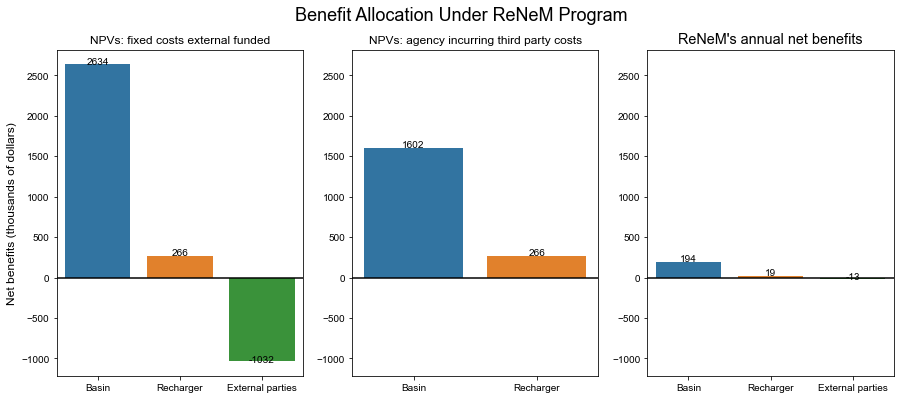

In [19]:
agency_static_npv, recharger_static_npv, tpc_static_npv = create_fig(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s_no,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,
           title="Benefit Allocation Under ReNeM Program",space=5)

### NPV With Static Infiltration Value & Baseline Payment 

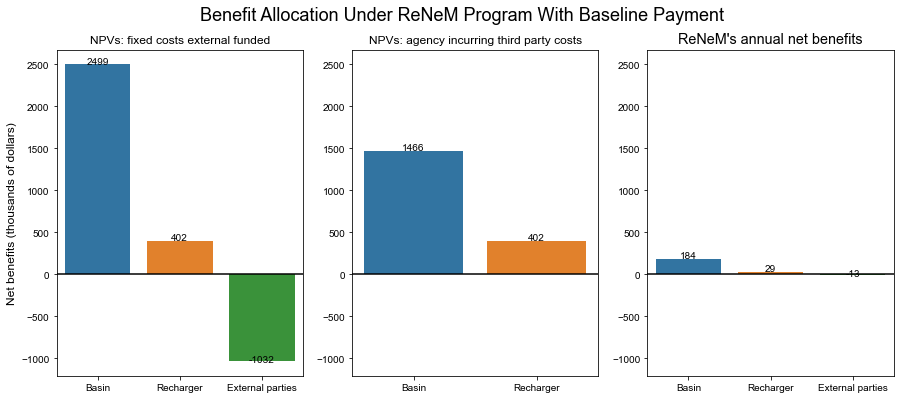

In [20]:
agency_baseline_static_npv, recharger_baseline_static_npv, tpc_baseline_static_npv = create_fig(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s_yes,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,
           title="Benefit Allocation Under ReNeM Program With Baseline Payment",space=5)

### Assessing distribution of benefits from set list of variable infiltration across project years 
Though the above assessment based on uniform infiltration across project years is useful analytically, it omits one crucial reality: precipitation has interannual variability. Though the existing sensitivity analysis attempts to address this concern by examining how shifting different variables' values influences the distribution of benefits, one key element is missing: rainfall variability (and by extension, infiltration variability). By not modeling this variability, we're unable to assess how this variability and its necessary impact on infiltration volume may impact distribution of benefits under the ReNeM program. With this weakness in mind, we want to repeat the above process but under a scenario in which infiltration volume varies year to year rather than remaining uniform across all project years. Incorporating variable infiltration amounts enables us to begin to assess the impact infiltration variability has on the distribution of benefits under ReNeM. 

#### Method 1: Extrapolation based on Watsonville rainfall gauge 
There may be several ways of incorporating infiltration volume variability into this analysis (i.e. using measured infiltration values from past years at existing project sites or simply plugging in realistic but made-up values). First, this section of the CBA extrapolates infiltration volumes from historic rainfall records at the Watsonville rainfall gauge. This approach was selected for two primary reasons. First, records at this gauge span water years 2002 - 2021, meaning there is great longevity to the time series. Second, extrapolating infiltration from real rainfall data is a simplification of the formula the Fisher Lab presently uses to estimate infiltration at each basin. Thus, though overly simplistic, it provides a defensible starting point than simply making up values. Watsonville rainfall gauge data can be accessed at: https://www.cnrfc.noaa.gov/rainfall_data.php.
 
Specifically, across water years 2002-2021 at the Watsonville rainfall gauge, average rainfall was 20.62 inches. Assuming average infiltration across these water years could have been 375 acre feet per year––the anticipated average infiltration across existing ReNeM project sites in the Pajaro Valley––and assuming linearity between rainfall and infiltration, we derive the following formula: 

    infiltration = rainfall * 18.19

We recognize that this formula likely overestimates infiltration during dry years, underestimates infiltration during wet years, and oversimplifies other hydrologic complexities. Despite these shortcomings, it is nonetheless useful for CBA purposes to make these assumptions in order to model the potential impact of rainfall variability on the distribution of benefits under ReNeM. 

#### NPV With Set List of Variable Infiltration Values from Watsonville
231.5199043, 367.0126999, 481.5905002, 292.6280645, 724.5681845, 493.2301497, 359.7048517, 179.3233509, 253.7079863, 272.4405473, 501.6788158, 501.4142783, 289.1725435, 287.1719788, 247.5244225, 588.5297804, 501.5961478, 364.4665266, 368.103917, 305.9045398

### NPV based on fixed infiltration value 

In [21]:
agency_npv_Qlist, recharger_npv_Qlist, tpc_npv_Qlist = get_npv_Qlist(n=n,Q=Q1,
   V=V,C=C,lam=lam,r=r,o=o,s=s_no,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,print_Qs = False)

In [22]:
agency_npv_Qlist_baseline, recharger_npv_Qlist_baseline, tpc_npv_Qlist_baseline = get_npv_Qlist(n=n,Q=Q1,   
   V=V,C=C,lam=lam,r=r,o=o,s=s_yes,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,print_Qs = False)

### Assessing distribution of benefits using stochasticity & Monte Carlo simulation of variable infiltration across all project years
Running a CBA based on a set list of variable infiltration values helps us assess the impact variable precipitation and infiltration may have on the allocation of benefits. However, because the list of infiltration values is set, our assessment is limited to the specific conditions we can extrapolate from that specific list of provided infiltration values. For instance, the ~170 acre feet of estimated infiltration for year 1 of the set list is relatively low and may have an outsized impact on NPV evaluations. 
 
The amount of water infiltrated at a ReNeM site is a key element of the rebate formula, meaning it has a substantial impact on how much money the agency, as a proxy for the basin, pays and how much money the recharger receives. The quantity of water infiltrated is in large part a product of rainfall quantity. Rainfall quantity can vary drastically year to year and decade to decade. However, absent probability distribution sampling (as in, with NPV calculations that assume uniform infiltration across all project years), this CBA altogether fails to account for the impact of variability on benefits distribution and, thus, the sensitivity analysis cannot consider how shifting variability influences benefits distribution. 
 
Put more simply, a CBA that does not model infiltration variability has limited utility for water management agencies. 
 
Unfortunately, we do not have the ability to predict rainfall amounts well into the future. As a consequence, if we want to consider the impact of rainfall variability on NPV calculations, rather than construct a CBA that looks at prospective rainfall variability, we must construct a CBA that looks at retrospective rainfall variability and must assume that future years will experience similar variability. We recognize that this approach is imperfect. Despite its imperfections, it is essential that this CBA attempt to model rainfall variability so that a wider range of water management agencies can reference this CBA and extrapolate its findings to their own local conditions. 
 
To this end and as explained above, we used rainfall data from the Watsonville rainfall gauge from water years 2002-2021 to estimate infiltration volume under the assumption that rainfall variation over the past 20 years and the coming 20 years will be comparable. Running this simulation once––what this CBA calls a "Set List of Variable Infiltration Values"––assumes that rainfall will be identical. However, again, this assumption limits the CBA's applicability because it remains case-specific, both in place and in time, to the Pajaro Valley from 2002-2021. 
 
To address this weakness, this CBA builds in a Monte Carlo simulation. Monte Carlo simulations model how the uncertainty and/or risk of an input variable can impact potential results. To this end, a Monte Carlo approach uses random sampling over numerous simulations to examine the distribution of potential outcomes. The Monte Carlo simulation method is preferable to alternative probability distribution simulation methods (i.e. Latin Hybercube Sampling) because its sampling method is truly randomized. 
 
Running a Monte Carlo simulation based on this list of infiltration values addresses this weakness. A Monte Carlo simulation accounts for risk by running through a range of possible outcomes and expressing the probabilities that those outcomes will occur. Within the guise of this CBA, this Monte Carlo simulation shows the range of possible net present values of ReNeM's benefits and the likelihood/frequency that those net present values will occur. To accomplish this, an infiltration value is selected at random from the provided list of potential Q values for each project year in order to produce a NPV. This process is repeated 10,000 with replacement for each of the 10,000 simulations. The 10,000 NPV amounts are then displayed on a histogram. 

### NPV With Stochastic Selection from List of Variable Infiltration Values & Without Baseline Payment 

In [23]:
aggregate_npv_stoch, aggregate_tpc_npv_stoch, agency_npv_stoch, recharger_npv_stoch, agency_npv_stoch_tpc_l, agency_npv_stoch_tpc = get_npvs_with_stochasticity(n=n,Q=Q1,
   V=V,C=C,lam=lam,r=r,o=o,s=s_no,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,print_Qs = True)

The Qs (infiltration volumes in afy) we use for NPV are:
[289.1725435 588.5297804 375.        231.5199043 292.6280645 292.6280645
 179.3233509 272.4405473 305.9045398 375.        368.103917  724.5681845
 375.        359.7048517 375.        375.        289.1725435 367.0126999
 359.7048517 179.3233509 375.        247.5244225 375.        364.4665266
 493.2301497]


In [24]:
aggregate_npv_stoch_list = []
aggregate_tpc_npv_stoch_list = []
agency_npv_stoch_list = []
recharger_npv_stoch_list = []
agency_npv_stoch_tpc_l_list = []
agency_npv_stoch_tpc_list = []

for i in range(10000):
    aggregate_npv_stoch, aggregate_tpc_npv_stoch, agency_npv_stoch, recharger_npv_stoch, agency_npv_stoch_tpc_l, agency_npv_stoch_tpc = get_npvs_with_stochasticity(n=n,Q=Q1,
    V=V,C=C,lam=lam,r=r,o=o,s=s_no,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc, seed=i, print_Qs=False)
    
    aggregate_npv_stoch_list.append(aggregate_npv_stoch)
    aggregate_tpc_npv_stoch_list.append(aggregate_tpc_npv_stoch)
    agency_npv_stoch_list.append(agency_npv_stoch)
    recharger_npv_stoch_list.append(recharger_npv_stoch)
    agency_npv_stoch_tpc_l_list.append(agency_npv_stoch_tpc_l) 
    agency_npv_stoch_tpc_list.append(agency_npv_stoch_tpc)

In [25]:
recharger_mean = np.mean(recharger_npv_stoch_list)/1000
print(recharger_mean)
basin_mean = np.mean(agency_npv_stoch_tpc_l_list)/1000
print(basin_mean)

274.2578396417403
1632.4175003843654


## Boxplot version

In [26]:
total_npv = np.array(recharger_npv_stoch_list) + np.array(agency_npv_stoch_tpc_l_list)

y = [np.array(total_npv)/1000000,
     np.array(agency_npv_stoch_tpc_l_list)/1000000, 
     np.array(recharger_npv_stoch_list)/1000000]

In [27]:
r_median_round = round(np.median(recharger_npv_stoch_list),-4).astype(int)
a_median_round = round(np.median(agency_npv_stoch_tpc_l_list),-4).astype(int)
t_median_round = round(np.median(total_npv),-4).astype(int)

In [28]:
t_median_round

1900000

## Barplot with error bars version

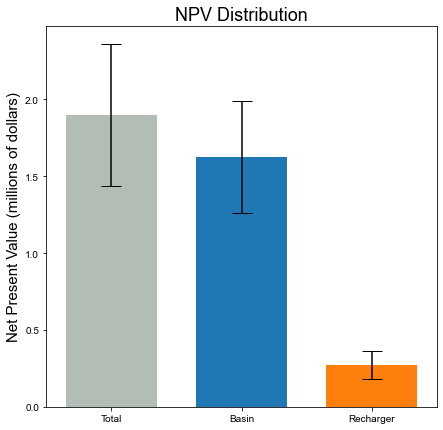

In [29]:
fig, ax =plt.subplots(1, figsize=(7,7))

ax.bar(["Total","Basin","Recharger"], [np.median(y[0]), np.median(y[1]), np.median([y[2]])],
       color =["#B2BEB5","#1f77b4","#ff7f0e" ],
        width = 0.7,capsize=10, 
       yerr= [
           np.std(total_npv/1000000) * 1.96,
           np.std(np.array(agency_npv_stoch_tpc_l_list)/1000000) * 1.96,
           np.std(np.array(recharger_npv_stoch_list)/1000000)*1.96
       ])

#ax.text(.04,t_median_round/1000000 + .04, r"$"+"{:,} million".format(t_median_round/1e6), size=11)
#ax.text(1.04,a_median_round/1000000 + .04, r"$"+"{:,} million".format(a_median_round/1e6), size=11)
#ax.text(1.49,r_median_round/1000000 + .04, r"$"+"{:,} million".format(r_median_round/1e6), size=11)

ax.set_xlim(-.5,2.5)
ax.set_ylabel("Net Present Value (millions of dollars)", size=15)
#plt.tight_layout()
ax.set_title("NPV Distribution", size=18)
fig.savefig("Fig2_barplot_with_error_bars_ls_2022_11_4.png", dpi=300)
fig.savefig("Fig2_barplot_with_error_bars_ls_2022_11_4.pdf", dpi=300)

In [30]:
np.std(total_npv/1000)

234.87618178512525

In [31]:
np.std(total_npv/1000) * 1.96

460.3573162988455

***

### NPV With Stochastic Selection from List of Variable Infiltration Values & With Baseline Payment 

In [32]:
aggregate_npv_stoch, aggregate_tpc_npv_stoch, agency_npv_stoch_baseline, recharger_npv_stoch_baseline, agency_npv_stoch_tpc_l_baseline, agency_npv_stoch_tpc_baseline = get_npvs_with_stochasticity(n=n,Q=Q1,
   V=V,C=C,lam =lam,r=r,o=o,s=s_yes,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,print_Qs = True)

The Qs (infiltration volumes in afy) we use for NPV are:
[289.1725435 588.5297804 375.        231.5199043 292.6280645 292.6280645
 179.3233509 272.4405473 305.9045398 375.        368.103917  724.5681845
 375.        359.7048517 375.        375.        289.1725435 367.0126999
 359.7048517 179.3233509 375.        247.5244225 375.        364.4665266
 493.2301497]


In [33]:
aggregate_list = []
aggregate_tpc_list = []
agency_npv_stoch_baseline_list = []
recharger_npv_stoch_baseline_list = []
agency_npv_stoch_tpc_l_baseline_list = []
agency_npv_stoch_tpc_baseline_list = []

for i in range(10000):
    aggregate_npv_stoch, aggregate_tpc_npv_stoch, agency_npv_stoch_baseline, recharger_npv_stoch_baseline, agency_npv_stoch_tpc_l_baseline, agency_npv_stoch_tpc_baseline = get_npvs_with_stochasticity(n=n,Q=Q1,
    V=V,C=C,lam=lam,r=r,o=o,s=s_yes,a=a,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc, seed=i, print_Qs=False)
    
    aggregate_list.append(aggregate_npv_stoch)
    aggregate_tpc_list.append(aggregate_tpc_npv_stoch)
    agency_npv_stoch_baseline_list.append(agency_npv_stoch_baseline)
    recharger_npv_stoch_baseline_list.append(recharger_npv_stoch_baseline)
    agency_npv_stoch_tpc_l_baseline_list.append(agency_npv_stoch_tpc_l_baseline)
    agency_npv_stoch_tpc_baseline_list.append(agency_npv_stoch_tpc_baseline)

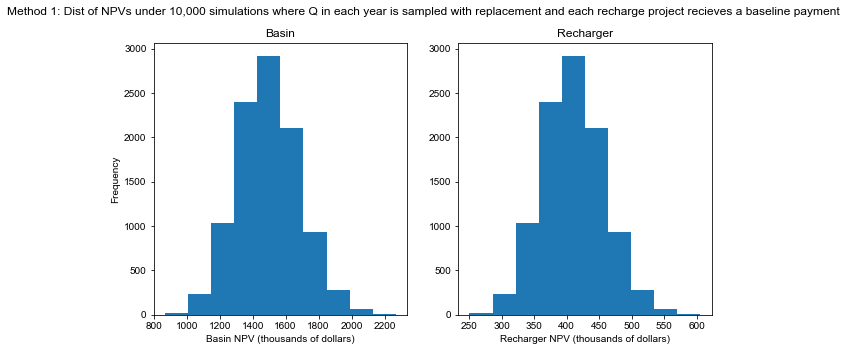

In [34]:
##May want to add in third subplot that shows Basin NPV when it internalizes tpc costs## ! 

fig, ax = plt.subplots(1,2, figsize= (10,5))

_ =  ax[0].hist(np.array(agency_npv_stoch_tpc_l_baseline_list)/1000, density=False)
_ =  ax[1].hist(np.array(recharger_npv_stoch_baseline_list)/1000, density=False)

ax[0].set_title("Basin")
ax[1].set_title("Recharger")

ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Basin NPV (thousands of dollars)")
ax[1].set_xlabel("Recharger NPV (thousands of dollars)")
_ = fig.suptitle("Method 1: Dist of NPVs under 10,000 simulations where Q in each year is sampled with replacement and each recharge project recieves a baseline payment")

fig.savefig("SI_MC distributionwith baseline" + ".png")
fig.savefig("SI_ALL_MC distributionwith baseline" + ".pdf")

### Comparing NPVs for Rechargers & the Basin Based on These Three Methods for Modeling Infiltration Amounts

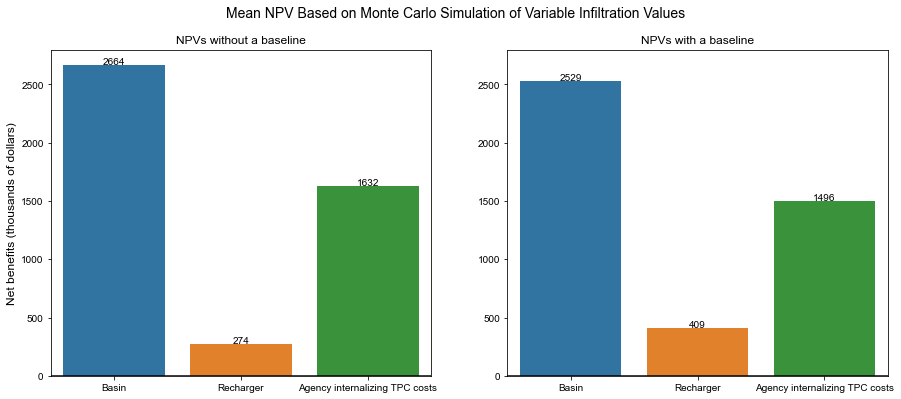

In [35]:
aggregate_avg_npv_from_stoch = np.mean(aggregate_npv_stoch_list)/1000
aggregate_tpc_avg_npv_from_stoch = np.mean(aggregate_tpc_npv_stoch_list)/1000
agency_avg_npv_from_stoch = np.mean(agency_npv_stoch_list)/1000
recharger_avg_npv_from_stoch = np.mean(recharger_npv_stoch_list)/1000
agency_avg_tpc_npv_fig_from_stoch = agency_avg_npv_from_stoch + tpc_static_npv

agency_avg_npv_from_stoch_baseline = np.mean(agency_npv_stoch_baseline_list)/1000
recharger_avg_npv_from_stoch_baseline = np.mean(recharger_npv_stoch_baseline_list)/1000
agency_avg_tpc_npv_fig_from_stoch_baseline = agency_avg_npv_from_stoch_baseline + tpc_static_npv

create_fig_stoch(agency_npv_fig_stoch=agency_avg_npv_from_stoch,
                 recharger_npv_fig_stoch=recharger_avg_npv_from_stoch,
                 agency_tpc_npv_fig_stoch=agency_avg_tpc_npv_fig_from_stoch,
                 
                 agency_npv_baseline_fig_stoch = agency_avg_npv_from_stoch_baseline,
                 recharger_npv_baseline_fig_stoch= recharger_avg_npv_from_stoch_baseline,
                 agency_tpc_npv_baseline_fig_stoch= agency_avg_tpc_npv_fig_from_stoch_baseline,
              title="Mean NPV Based on Monte Carlo Simulation of Variable Infiltration Values",space=5)

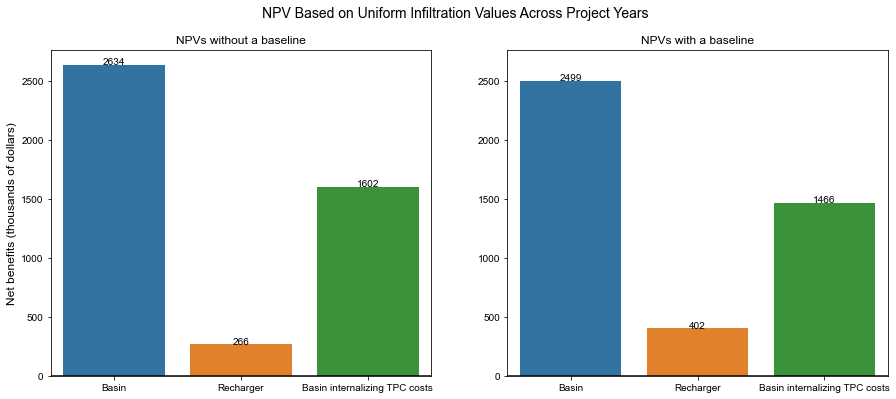

In [36]:
create_fig_uniform(agency_npv_uniform= agency_static_npv,
                recharger_npv_uniform=recharger_static_npv,
                agency_tpc_npv_uniform=agency_static_npv+tpc_static_npv,
                agency_npv_baseline_uniform=agency_baseline_static_npv,
                recharger_npv_baseline_uniform=recharger_baseline_static_npv,
                agency_tpc_npv_baseline_uniform=agency_baseline_static_npv+tpc_baseline_static_npv,
              title="NPV Based on Uniform Infiltration Values Across Project Years",space=5)

In [37]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['gray','#1f77b4','#ff7f0e']) 

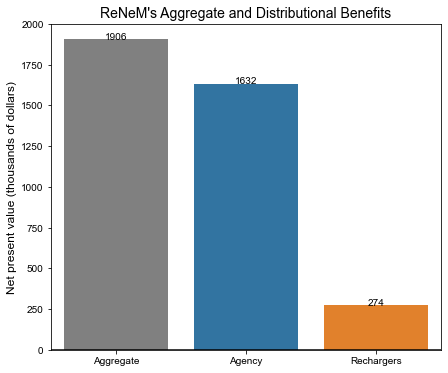

In [38]:
create_fig_final_nolabels(aggregate_tpc_npv_fig_stoch=aggregate_tpc_avg_npv_from_stoch,
                 recharger_npv_fig_stoch=recharger_avg_npv_from_stoch,
                 agency_tpc_npv_fig_stoch=agency_avg_tpc_npv_fig_from_stoch,
                 title="ReNeM's Aggregate and Distributional Benefits",space=5)

In [39]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['gray', '#C0C0C0', '#2ca02c', '#98df8a', '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78']) 

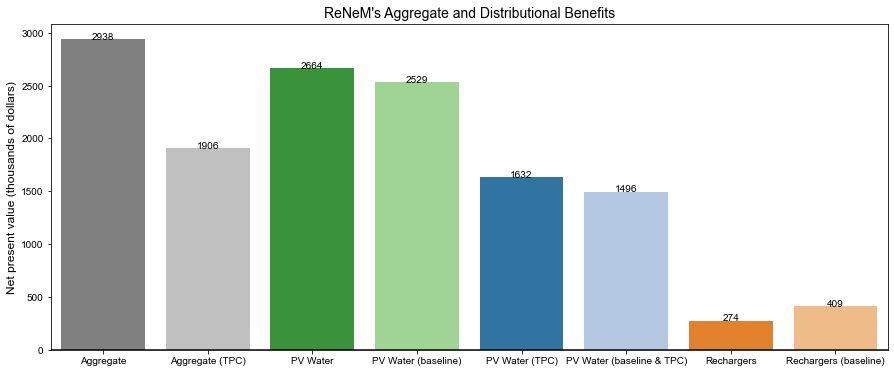

In [40]:
create_fig_final(aggregate_npv_fig_stoch = aggregate_avg_npv_from_stoch,
                 aggregate_tpc_npv_fig_stoch = aggregate_tpc_avg_npv_from_stoch,
                 agency_npv_fig_stoch = agency_avg_npv_from_stoch,
                 agency_npv_baseline_fig_stoch = agency_avg_npv_from_stoch_baseline,
                 recharger_npv_fig_stoch = recharger_avg_npv_from_stoch,
                 recharger_npv_baseline_fig_stoch = recharger_avg_npv_from_stoch_baseline,
                 agency_tpc_npv_fig_stoch = agency_avg_tpc_npv_fig_from_stoch,
                 agency_tpc_npv_baseline_fig_stoch = agency_avg_tpc_npv_fig_from_stoch_baseline,
                 title = "ReNeM's Distribution of Benefits Under Different Scenarios",space=5)